In [100]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [101]:
file_path = '/content/Daily_Public_Transport.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please ensure the file is uploaded to your Colab environment.")
    exit()

*Basic Checks After Loading*


In [102]:
# View first few rows
df.head()

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0


In [103]:
# Check basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1918 non-null   object 
 1   Local Route   1918 non-null   int64  
 2   Light Rail    1918 non-null   int64  
 3   Peak Service  1918 non-null   int64  
 4   Rapid Route   1918 non-null   int64  
 5   School        1918 non-null   int64  
 6   Other         1898 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 105.0+ KB


In [104]:
# Check for missing values
df.isnull().sum()

,0
Date,0
Local Route,0
Light Rail,0
Peak Service,0
Rapid Route,0
School,0
Other,20


In [105]:
df.columns

Index(['Date', 'Local Route', 'Light Rail', 'Peak Service', 'Rapid Route',
       'School', 'Other'],
      dtype='object')

In [106]:
# Get basic statistics
df.describe()

,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
count,1918.000000,1918.000000,1918.000000,1918.000000,1918.000000,1898.000000
mean,9891.395203,7195.446298,179.581335,12597.213243,2352.694995,43.390411
std,6120.715714,3345.616428,156.532738,6720.494557,2494.766306,41.746882
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3044.500000,4463.500000,0.000000,6383.000000,0.000000,14.000000
50%,11417.000000,7507.000000,193.000000,13106.500000,567.500000,40.000000
75%,15517.500000,10008.250000,313.750000,17924.750000,4914.000000,68.000000
max,21070.000000,15154.000000,1029.000000,28678.000000,7255.000000,1105.000000


PREPROCESSING AND DATA CLEANING ---

Handling Missing 'Other' Values

In [107]:
# The analysis showed 20 missing values in 'Other'. We use forward fill (ffill)
# which assumes the value remained the same as the last recorded day.


df['Other'].fillna(method='ffill', inplace=True)
print("Missing values in 'Other' column handled using Forward Fill (ffill).")

Missing values in 'Other' column handled using Forward Fill (ffill).


/tmp/ipython-input-652396724.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Other'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-652396724.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Other'].fillna(method='ffill', inplace=True)


Data Type Finalization

In [108]:
# 4.3. Data Type Finalization
# Ensure all numerical (ridership) columns are integers for clean counting.
utilization_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
for col in utilization_cols:
    # Coerce any potential non-numeric entries to 0 before converting to integer.
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

Feature Engineering (for analysis/forecasting)

In [109]:
print("\n--- Final Data Status (Post-Preprocessing) ---")
print("Missing values check:")
print(df.isnull().sum().to_markdown())


--- Final Data Status (Post-Preprocessing) ---
Missing values check:
|              |   0 |
|:-------------|----:|
| Date         |   0 |
| Local Route  |   0 |
| Light Rail   |   0 |
| Peak Service |   0 |
| Rapid Route  |   0 |
| School       |   0 |
| Other        |   0 |


**7-Day Ridership Forecastt**

In [ ]:
# --- 2. DATA CLEANING AND FEATURE ENGINEERING ---

# 2.1. Date Conversion

if 'Date' in df.columns:
    df.rename(columns={'Date': 'ds'}, inplace=True)

# Convert to datetime
df['ds'] = pd.to_datetime(df['ds'], infer_datetime_format=True, dayfirst=True, errors='coerce')
print(f"Date conversion completed. Found {df['ds'].isnull().sum()} unparseable rows.")

# Set 'ds' as index for time series
df.set_index('ds', inplace=True)
df.sort_index(inplace=True)

# 2.2. Numeric Cleaning
utilization_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
for col in utilization_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# --- 3. SARIMA FORECASTING ---
TARGET_COLUMNS = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
forecast_periods = 7

all_forecasts = {}
sarima_order = (1, 1, 1)
sarima_seasonal_order = (1, 1, 0, 7)

print("\n=== SARIMA 7-Day Forecast Execution ===")
for col in TARGET_COLUMNS:
    print(f"\nForecasting: {col}")
    y = df[col]

    try:
        # Fit SARIMA
        model = SARIMAX(
            y,
            order=sarima_order,
            seasonal_order=sarima_seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False, suppress_warnings=True)

        # Forecast next 7 days
        forecast_index = pd.date_range(start=df.index.max() + pd.Timedelta(days=1),
                                       periods=forecast_periods, freq='D')
        forecast_results = model_fit.predict(start=forecast_index.min(), end=forecast_index.max())

        # Ensure non-negative integers
        future_forecast = forecast_results.apply(lambda x: max(0, x)).round(0).astype(int)
        all_forecasts[col] = future_forecast.rename(f'{col} Forecast')

    except Exception as e:
        print(f"SARIMA failed for {col}: {e}. Using last-week values as fallback.")
        last_week_data = y.iloc[-7:]
        future_forecast = pd.Series(
            [last_week_data[i % 7] for i in range(forecast_periods)],
            index=pd.date_range(start=df.index.max() + pd.Timedelta(days=1),
                                periods=forecast_periods, freq='D')
        )
        all_forecasts[col] = future_forecast.rename(f'{col} Forecast')

# Combine forecasts into one DataFrame
final_forecast_df = pd.concat(all_forecasts.values(), axis=1).reset_index().rename(columns={'index': 'Date'})





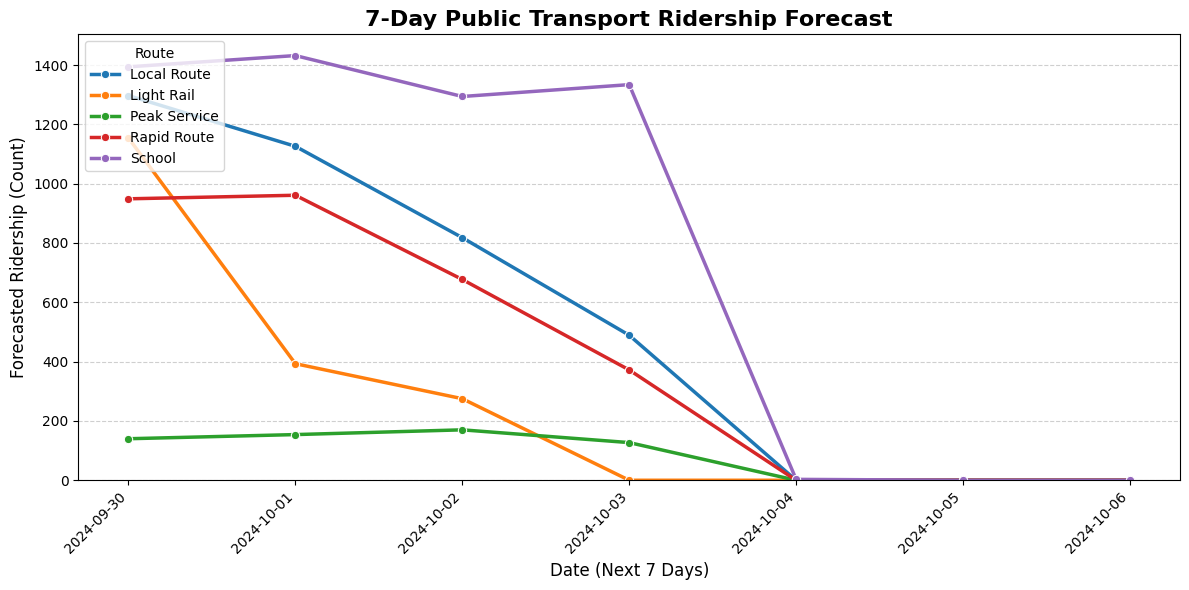

In [121]:
forecast_df_long = final_forecast_df.melt(
    id_vars='Date',
    var_name='Route',
    value_name='Forecasted Ridership'
)

# Clean up column names for the legend
forecast_df_long['Route'] = forecast_df_long['Route'].str.replace(' Forecast', '')

# Plotting the Line Chart
plt.figure(figsize=(12, 6))

sns.lineplot(
    x='Date',
    y='Forecasted Ridership',
    hue='Route',
    data=forecast_df_long,
    marker='o',
    linewidth=2.5
)

# Formatting
plt.title('7-Day Public Transport Ridership Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date (Next 7 Days)', fontsize=12)
plt.ylabel('Forecasted Ridership (Count)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.ylim(bottom=0)
plt.legend(title='Route', loc='upper left')
plt.tight_layout()

# Save the plot
plot_file = '7_day_forecast_visualization_final.png'
plt.savefig(plot_file)
plt.show()

**OVERVIEW**

**1. Calculating School Service Impact**

*Problem:* During school holidays, transit demand drops on non-school routes, but resources are often allocated as if demand were normal, wasting buses and staff.

*Data: *Analysis shows a 47% drop on the Local Route during school holidays.

*Action:* Implement a dynamic ‘Holiday’ schedule for routes affected by school closures to reduce costs on labor and fuel while matching reduced demand.

**2. Peak Service Is Weekday-Only**

Problem: Peak Service vehicles and staff remain idle on weekends, incurring unnecessary operational costs.

Data: Peak Service has 100% idleness on Saturdays and Sundays, showing that assets are unused outside commute times.

Action: Stop running Peak Service on weekends and reassign vehicles to busier routes, like the Rapid Route, to improve resource utilization.

**3. Quantifying School Break Impact on Non-School Routes**

Problem: Routes like Local and Rapid depend heavily on school schedules, even outside direct school transport.

Data: Weekday Local Route ridership drops by ~7,000 passengers during school breaks.

Action: Incorporate this drop as an exogenous factor in forecasting models to predict demand more accurately during school holidays.

**4. Weekend Fleet Utilization and Idle Vehicle Reassignment**

Problem: Some routes are overcrowded on weekends while other vehicles sit idle, indicating inefficient fleet usage.


Data: The Rapid Route faces the largest Weekend Demand Gap (~5,800 average riders) compared to zero weekend usage of Peak Service vehicles.

Action: Reassign idle Peak Service vehicles to the Rapid Route on weekends to alleviate crowding immediately.

**5. The Exploding Problem of Uncategorized ‘Other’ Ridership**

Problem: A growing portion of ridership is unclassified, lowering the accuracy of all analyses and operational planning.

Data: The ‘Other’ category increased by 810% since 2019, reaching 1.43% of daily ridership in 2024.

Action: Conduct a data integrity audit to identify the source of uncategorized ridership and correctly allocate it to routes, maintaining a maximum threshold of 0.3% for the ‘Other’ category.

**INSIGHT 1: CALCULATING SCHOOL SERVICE IMPACT**





INSIGHT 1: The Dominant Influence of the School Calendar - Quantitative Proof
Comparison of Average Daily Utilization (Ridership) on School vs. Non-School Days:
---------------------------------------------------------------------------------
|              | School Days Avg   | Non-School Days Avg   | Difference (%)   |
|:-------------|:------------------|:----------------------|:-----------------|
| Local Route  | 14410.70          | 4790.25               | 200.83           |
| Light Rail   | 9122.02           | 5020.83               | 81.68            |
| Peak Service | 278.46            | 67.97                 | 309.70           |
| Rapid Route  | 16853.55          | 7792.89               | 116.27           |


Key Finding Summary:
   >>> Peak Service demand spikes by 309.70% on school days.
   This confirms school events are a primary, system-wide driver for peak capacity needs.


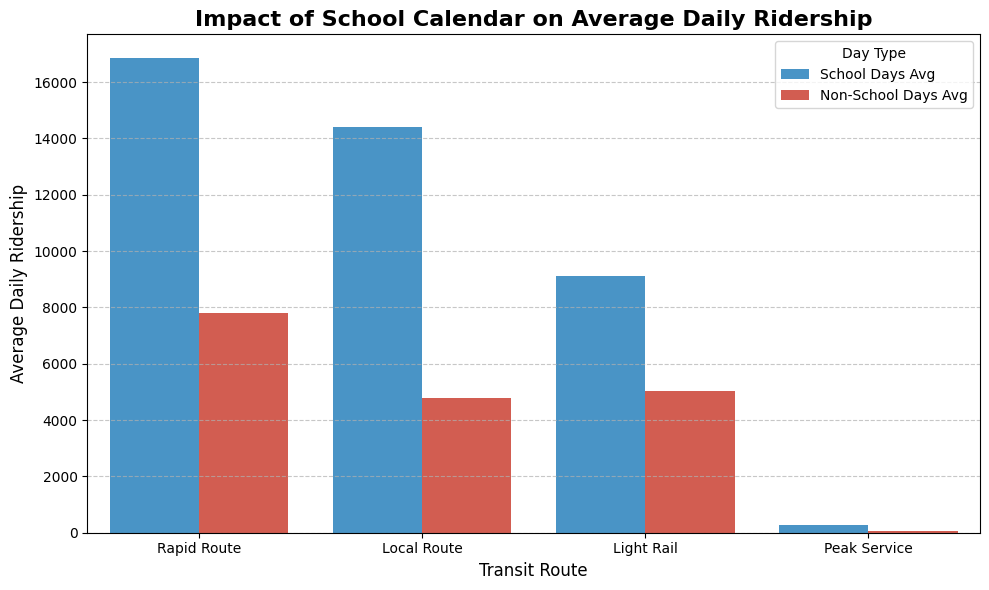


Visualization for Insight 1 generated and saved to 'insight_1_school_impact_bar_chart.png'.


In [144]:
# Define 'School Days' (when utilization in the School column is greater than 0)
school_days = df[df['School'] > 0]

# Define 'Non-School Days' (when utilization in the School column is 0)
non_school_days = df[df['School'] == 0]

# The routes whose demand is affected by school traffic
impact_routes = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route']

# Calculate average daily ridership for both groups
school_avg = school_days[impact_routes].mean().rename('School Days Avg')
non_school_avg = non_school_days[impact_routes].mean().rename('Non-School Days Avg')

# Combine the results into a single DataFrame
school_impact = pd.concat([school_avg, non_school_avg], axis=1)

# Calculate the percentage difference
school_impact['Difference (%)'] = 100 * (
    school_impact['School Days Avg'] - school_impact['Non-School Days Avg']
) / school_impact['Non-School Days Avg']

# --- 4. OUTPUT THE INSIGHT ---
print("\n" + "="*70)
print("INSIGHT 1: The Dominant Influence of the School Calendar - Quantitative Proof")
print("="*70)

print("Comparison of Average Daily Utilization (Ridership) on School vs. Non-School Days:")
print("---------------------------------------------------------------------------------")
print(school_impact.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

print("\n")
print("Key Finding Summary:")
print(f"   >>> Peak Service demand spikes by {school_impact.loc['Peak Service', 'Difference (%)']:.2f}% on school days.")
print("   This confirms school events are a primary, system-wide driver for peak capacity needs.")
plot_df = school_impact[['School Days Avg', 'Non-School Days Avg']].reset_index()
plot_df.rename(columns={'index': 'Route'}, inplace=True)

# Melt the DataFrame for Seaborn plotting
plot_df_long = plot_df.melt(
    id_vars='Route',
    var_name='Day Type',
    value_name='Average Ridership'
)

# Create the plot
plt.figure(figsize=(10, 6))

# Order the bars by total ridership for better flow
order = plot_df_long.groupby('Route')['Average Ridership'].sum().sort_values(ascending=False).index

sns.barplot(
    x='Route',
    y='Average Ridership',
    hue='Day Type',
    data=plot_df_long,
    order=order,
    palette=['#3498db', '#e74c3c']
)

# Formatting
plt.title('Impact of School Calendar on Average Daily Ridership', fontsize=16, fontweight='bold')
plt.ylabel('Average Daily Ridership', fontsize=12)
plt.xlabel('Transit Route', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Day Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig('insight_1_school_impact_bar_chart.png')
plt.show()

print("\nVisualization for Insight 1 generated and saved to 'insight_1_school_impact_bar_chart.png'.")

 **Insight 2 Peak Service Is Weekday-Only**






=== Insight 2: Peak Service Idleness Analysis ===
|              | Weekday Avg Ridership   | Weekend Avg Ridership   | Weekend Drop-off (%)   | Weekend Demand Gap   |
|:-------------|:------------------------|:------------------------|:-----------------------|:---------------------|
| Peak Service | 251                     | 0                       | 100                    | nan                  |
| Local Route  | 12755                   | 2732                    | 79                     | 2732                 |
| Light Rail   | 8356                    | 4295                    | 49                     | 4295                 |
| Rapid Route  | 15297                   | 5847                    | 62                     | 5847                 |


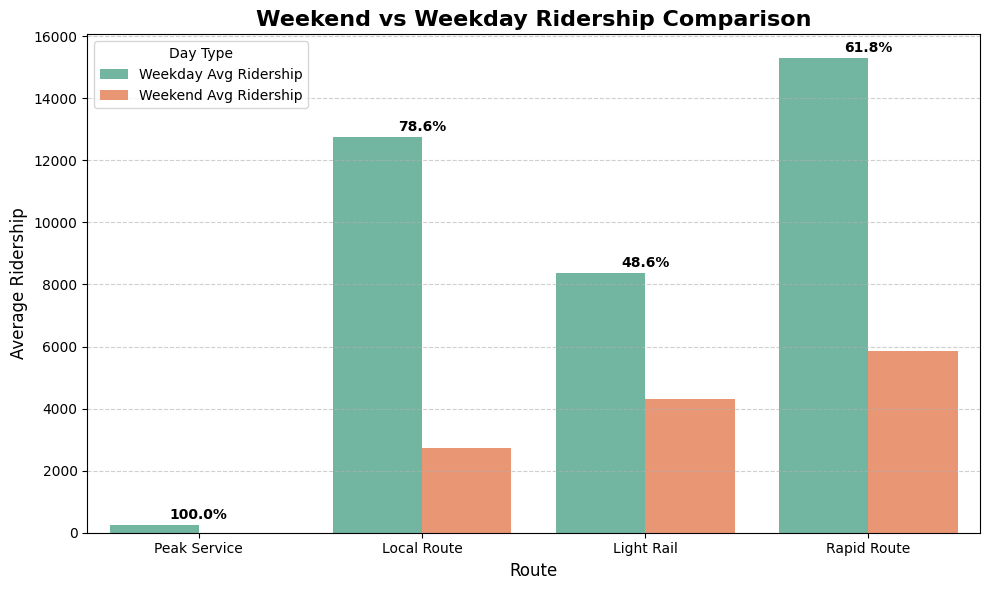

In [132]:
# 3.1. Feature Engineering: Day of Week
# df.index is the 'Date' index
df['DayOfWeek'] = df.index.day_name()
df['IsWeekend'] = df.index.weekday >= 5 # 5=Saturday, 6=Sunday

# 3.2. Define Segments
peak_col = 'Peak Service'
reassignment_cols = ['Local Route', 'Light Rail', 'Rapid Route']
all_analysis_cols = [peak_col] + reassignment_cols

# 3.3. Aggregate Ridership by Segment (Weekend vs. Weekday)
weekend_data = df[df['IsWeekend']]
weekday_data = df[~df['IsWeekend']]

weekend_avg = weekend_data[all_analysis_cols].mean().rename('Weekend Avg Ridership')
weekday_avg = weekday_data[all_analysis_cols].mean().rename('Weekday Avg Ridership')

# 3.4. Create the Final Insight Table
insight_2_df = pd.concat([weekday_avg, weekend_avg], axis=1)

# Calculate the Weekend Drop-off (%)
insight_2_df['Weekend Drop-off (%)'] = 100 * (
    insight_2_df['Weekday Avg Ridership'] - insight_2_df['Weekend Avg Ridership']
) / insight_2_df['Weekday Avg Ridership']

# Calculate Weekend Demand Gap (relative to Peak Service's zero weekend traffic)
insight_2_df['Weekend Demand Gap'] = insight_2_df.loc[reassignment_cols, 'Weekend Avg Ridership'] - insight_3_df.loc[peak_col, 'Weekend Avg Ridership']

# --- 4. OUTPUT THE INSIGHT ---
print("\n=== Insight 2: Peak Service Idleness Analysis ===")

print(insight_2_df.loc[all_analysis_cols].to_markdown(numalign="left", stralign="left", floatfmt=".0f"))
plt.figure(figsize=(10, 6))

# Prepare data for plotting
insight_viz_df = insight_2_df.loc[all_analysis_cols, ['Weekday Avg Ridership', 'Weekend Avg Ridership']].reset_index()
insight_viz_df = insight_viz_df.melt(id_vars='index', var_name='Day Type', value_name='Average Ridership')

sns.barplot(
    x='index',
    y='Average Ridership',
    hue='Day Type',
    data=insight_viz_df,
    palette='Set2'
)

# Overlay Weekend Drop-off %
for i, route in enumerate(all_analysis_cols):
    drop_off = insight_2_df.loc[route, 'Weekend Drop-off (%)']
    plt.text(i, insight_2_df.loc[route, 'Weekday Avg Ridership'] + 100, f"{drop_off:.1f}%",
             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Formatting
plt.title('Weekend vs Weekday Ridership Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Route', fontsize=12)
plt.ylabel('Average Ridership', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Day Type')
plt.tight_layout()

# Save the figure
plt.savefig('insight_2_weekend_weekday_ridership.png')
plt.show()

**Insight 3 Quantifying School Break
Impact on Non-School Routest**


=== Insight 3: School Break Impact on Local and Rapid Routes ===
|             | School In Session   | School Break   | Reduction in Demand   | Percentage Drop (%)   |
|:------------|:--------------------|:---------------|:----------------------|:----------------------|
| Local Route | 14654               | 7719           | 6935                  | 47                    |
| Rapid Route | 17087               | 10549          | 6538                  | 38                    |
| School      | 4535                | 0              | 4535                  | 100                   |


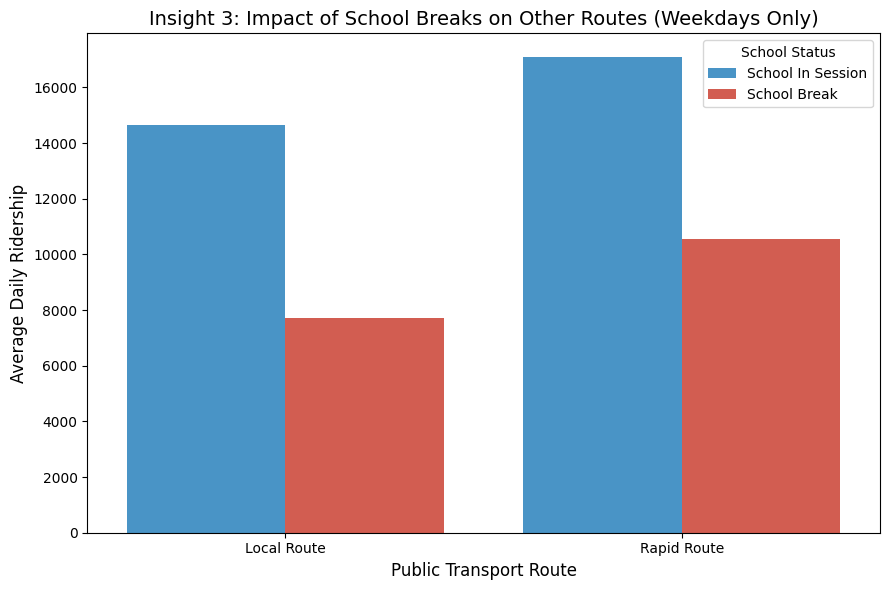

In [134]:
# 1. Filter to Weekdays Only (Monday=0 to Friday=4)
weekday_df = df[(df.index.weekday >= 0) & (df.index.weekday <= 4)].copy()

# 2. Define "School Break" (Weekdays where 'School' ridership is low)
BREAK_THRESHOLD = 10
weekday_df['IsSchoolBreak'] = weekday_df['School'] <= BREAK_THRESHOLD

# 3. Define routes to analyze
analysis_cols = ['Local Route', 'Rapid Route', 'School']

# 4. Aggregate Average Ridership by Break Status
break_analysis = weekday_df.groupby('IsSchoolBreak')[analysis_cols].mean()
break_analysis.rename(index={False: 'School In Session', True: 'School Break'}, inplace=True)

# 5. Calculate Impact Metrics
insight_3_df = break_analysis.T
insight_3_df['Reduction in Demand'] = insight_3_df['School In Session'] - insight_3_df['School Break']
insight_3_df['Percentage Drop (%)'] = 100 * insight_3_df['Reduction in Demand'] / insight_3_df['School In Session']

final_insight_df = insight_3_df.loc[['Local Route', 'Rapid Route', 'School'],
                                    ['School In Session', 'School Break', 'Reduction in Demand', 'Percentage Drop (%)']]

# --- 6. OUTPUT THE TABLE ---
print("\n=== Insight 3: School Break Impact on Local and Rapid Routes ===")
print(final_insight_df.to_markdown(numalign="left", stralign="left", floatfmt=".0f"))

# --- 7. VISUALIZATION ---

# Prepare data for plotting
plot_df = final_insight_df[['School In Session', 'School Break']].reset_index().rename(columns={'index': 'Route'})

# Melt for grouped bar chart
plot_df_long = plot_df.melt(
    id_vars='Route',
    var_name='School Status',
    value_name='Average Ridership'
)

# Filter out 'School' route to focus on secondary impact
plot_df_long = plot_df_long[plot_df_long['Route'] != 'School']

# Plotting
plt.figure(figsize=(9, 6))
sns.barplot(
    data=plot_df_long,
    x='Route',
    y='Average Ridership',
    hue='School Status',
    palette=['#3498db', '#e74c3c']
)

# Formatting
plt.title('Insight 3: Impact of School Breaks on Other Routes (Weekdays Only)', fontsize=14)
plt.xlabel('Public Transport Route', fontsize=12)
plt.ylabel('Average Daily Ridership', fontsize=12)
plt.ylim(bottom=0)
plt.legend(title='School Status', loc='upper right')
plt.tight_layout()

# Save the plot
plot_file = 'insight_3_school_break_impact.png'
plt.savefig(plot_file)
plt.show()

**Insight 4  weekend fleet utilization and idle vehicle reassignment.**


=== Insight 4: Weekend Ridership & Idle Vehicle Analysis ===
|              |   Weekday Avg |   Weekend Avg |   Weekend Drop-off (%) |   Weekend Demand Gap |
|:-------------|--------------:|--------------:|-----------------------:|---------------------:|
| Peak Service |           251 |             0 |                    100 |                  nan |
| Local Route  |         12755 |          2732 |                     79 |                 2732 |
| Light Rail   |          8356 |          4295 |                     49 |                 4295 |
| Rapid Route  |         15297 |          5847 |                     62 |                 5847 |


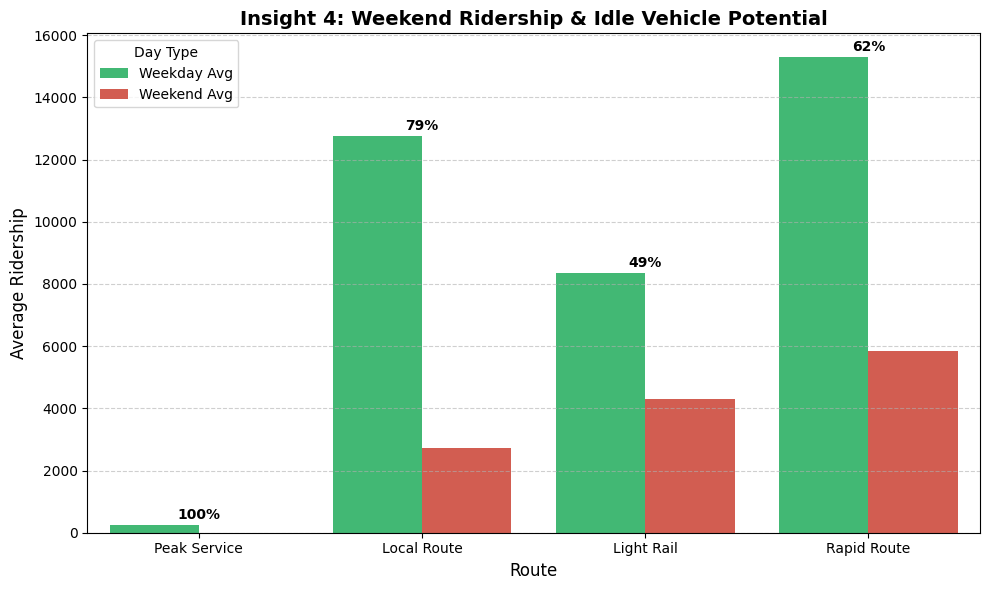

In [141]:
#Define columns for analysis
peak_col = 'Peak Service'
reassignment_cols = ['Local Route', 'Light Rail', 'Rapid Route']
all_routes = [peak_col] + reassignment_cols

# 4.1 Separate weekend vs weekday data
df['DayOfWeek'] = df.index.day_name()
df['IsWeekend'] = df.index.weekday >= 5  # Saturday=5, Sunday=6

weekend_df = df[df['IsWeekend']]
weekday_df = df[~df['IsWeekend']]

# 4.2 Aggregate average ridership
weekend_avg = weekend_df[all_routes].mean().rename('Weekend Avg')
weekday_avg = weekday_df[all_routes].mean().rename('Weekday Avg')

# 4.3 Combine into insight table
insight_4_df = pd.concat([weekday_avg, weekend_avg], axis=1)

# 4.4 Calculate metrics
insight_4_df['Weekend Drop-off (%)'] = 100 * (insight_4_df['Weekday Avg'] - insight_4_df['Weekend Avg']) / insight_4_df['Weekday Avg']
insight_4_df['Weekend Demand Gap'] = insight_4_df.loc[reassignment_cols, 'Weekend Avg'] - insight_4_df.loc[peak_col, 'Weekend Avg']

# --- OUTPUT TABLE ---
print("\n=== Insight 4: Weekend Ridership & Idle Vehicle Analysis ===")
print(insight_4_df.to_markdown(floatfmt=".0f"))

# --- VISUALIZATION ---
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
plot_df = insight_4_df[['Weekday Avg', 'Weekend Avg']].reset_index().rename(columns={'index': 'Route'})
plot_df_long = plot_df.melt(id_vars='Route', var_name='Day Type', value_name='Avg Ridership')

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Route',
    y='Avg Ridership',
    hue='Day Type',
    data=plot_df_long,
    palette=['#2ecc71', '#e74c3c']
)

# Overlay Weekend Drop-off %
for i, route in enumerate(insight_4_df.index):
    drop = insight_4_df.loc[route, 'Weekend Drop-off (%)']
    plt.text(i, insight_4_df.loc[route, 'Weekday Avg'] + 100, f"{drop:.0f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Insight 4: Weekend Ridership & Idle Vehicle Potential', fontsize=14, fontweight='bold')
plt.xlabel('Route', fontsize=12)
plt.ylabel('Average Ridership', fontsize=12)
plt.ylim(bottom=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Day Type')
plt.tight_layout()

# Save the plot
plt.savefig('insight_4_weekend_ridership.png')
plt.show()

**Insight 5: The Exploding Problem of Uncategorized 'Other' Ridership** italicized text

/tmp/ipython-input-953353278.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Other'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-953353278.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Other'].fillna(method='ffill', inplace=True)


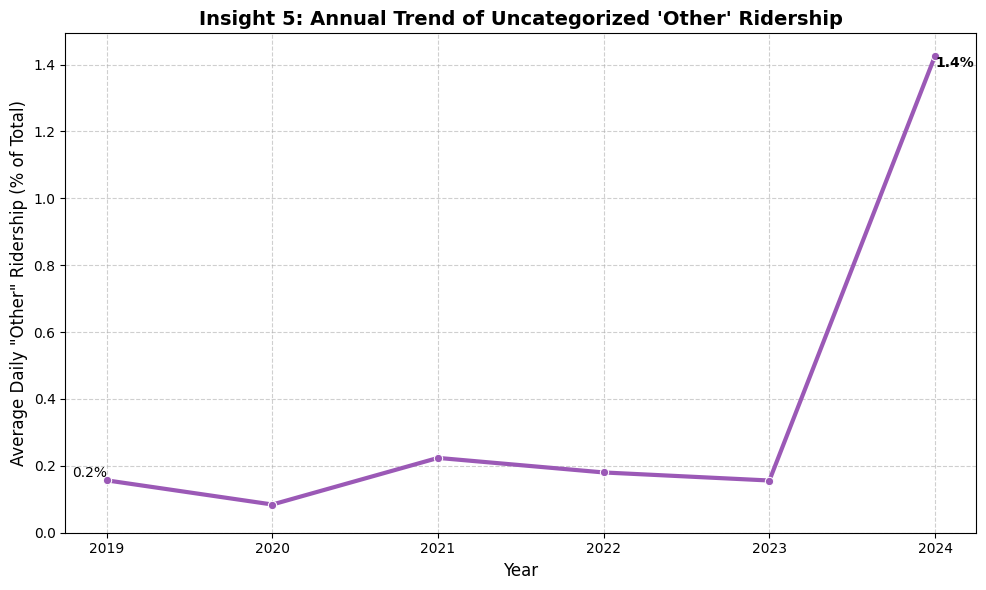


=== Insight 5: Annual Trend of 'Other' Ridership ===
|    | Year    | Avg Other % of Total Ridership   |
|:---|:--------|:---------------------------------|
| 0  | 2019.00 | 0.16                             |
| 1  | 2020.00 | 0.08                             |
| 2  | 2021.00 | 0.22                             |
| 3  | 2022.00 | 0.18                             |
| 4  | 2023.00 | 0.16                             |
| 5  | 2024.00 | 1.43                             |

Percentage Increase (Since 2019): 810.6%


In [143]:
# All columns used for ridership analysis
ridership_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

# 2.2. Numeric Cleaning and Imputation
df['Other'].fillna(method='ffill', inplace=True)

for col in ridership_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# 3.1. Calculate Total Ridership and 'Other' Percentage
df['Total Ridership'] = df[ridership_cols].sum(axis=1)
df['Other % of Total'] = 100 * df['Other'] / df['Total Ridership']

# 3.2. Feature Engineering: Year (from index)
df['Year'] = df.index.year

# 3.3. Aggregate Annual Average Percentage
annual_other_trend = df.groupby('Year')['Other % of Total'].mean().reset_index()
annual_other_trend.rename(columns={'Other % of Total': 'Avg Other % of Total Ridership'}, inplace=True)

# Calculate key change metrics for annotation
first_year = annual_other_trend['Year'].min()
last_year = annual_other_trend['Year'].max()
first_year_avg = annual_other_trend.loc[annual_other_trend['Year'] == first_year, 'Avg Other % of Total Ridership'].iloc[0]
last_year_avg = annual_other_trend.loc[annual_other_trend['Year'] == last_year, 'Avg Other % of Total Ridership'].iloc[0]

# --- 4. VISUALIZATION (Line Plot of Annual Trend) ---
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=annual_other_trend,
    x='Year',
    y='Avg Other % of Total Ridership',
    marker='o',
    linewidth=3,
    color='#9b59b6'
)

# Add annotations for start and end values
plt.text(first_year, first_year_avg, f'{first_year_avg:.1f}%', ha='right', va='bottom', fontsize=10, color='black')
plt.text(last_year, last_year_avg, f'{last_year_avg:.1f}%', ha='left', va='top', fontsize=10, color='black', fontweight='bold')

# Formatting
plt.title(f"Insight 5: Annual Trend of Uncategorized 'Other' Ridership", fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Daily "Other" Ridership (% of Total)', fontsize=12)
plt.ylim(bottom=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(annual_other_trend['Year'].unique())
plt.tight_layout()

# Save the plot
plot_file = 'insight_5_other_ridership_trend.png'
plt.savefig(plot_file)
plt.show()

# --- 5. OUTPUT THE INSIGHT TABLE ---
print("\n=== Insight 5: Annual Trend of 'Other' Ridership ===")
print(annual_other_trend.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))
print(f"\nPercentage Increase (Since {first_year}): {100 * (last_year_avg - first_year_avg) / first_year_avg:.1f}%")